# VAE for the CelebA dataset

> In this post, we will implement the variational AutoEncoder (VAE) for an image dataset of celebrity faces. This is the Programming Assignment of lecture "Probabilistic Deep Learning with Tensorflow 2" from Imperial College London.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow_probability, ICL]
- image: images/celeba-reconstruct.png

## Packages

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


![CelebA overview image](image/celeba.png)

## The Large-scale CelebFaces Attributes (CelebA) Dataset

For this assignment you will use a subset of the CelebFaces Attributes (CelebA) dataset. The full dataset contains over 200K images CelebA contains thousands of colour images of the faces of celebrities, together with tagged attributes such as 'Smiling', 'Wearing glasses', or 'Wearing lipstick'. It also contains information about bounding boxes and facial part localisation. CelebA is a popular dataset that is commonly used for face attribute recognition, face detection, landmark (or facial part) localization, and face editing & synthesis. 

* Z. Liu, P. Luo, X. Wang, and X. Tang. "Deep Learning Face Attributes in the Wild", Proceedings of International Conference on Computer Vision (ICCV), 2015.

You can read about the dataset in more detail [here](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). 

## Load the dataset

The following functions will be useful for loading and preprocessing the dataset. The subset you will use for this assignment consists of 10,000 training images, 1000 validation images and 1000 test images. These examples have been chosen to respect the original training/validation/test split of the dataset. 

> Note: Original dataset is too large to maintain in github. If you want it, please check the official pages.

In [3]:
# Function for loading the images

def load_dataset(split):
    train_list_ds = tf.data.Dataset.from_tensor_slices(np.load('./dataset/vae-celeba/{}.npy'.format(split)))
    train_ds = train_list_ds.map(lambda x: (x, x))
    return train_ds

In [4]:
# Load the training, validation and testing datasets splits

train_ds = load_dataset('train')
val_ds = load_dataset('val')
test_ds = load_dataset('test')

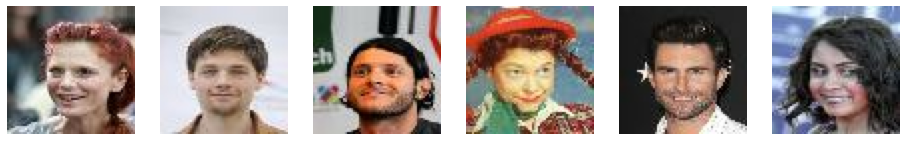

In [5]:
# Display a few examples

n_examples_shown = 6
f, axs = plt.subplots(1, n_examples_shown, figsize=(16, 3))

for j, image in enumerate(train_ds.take(n_examples_shown)):
    axs[j].imshow(image[0])
    axs[j].axis('off')

In [6]:
# Batch the Dataset objects

batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

## Mixture of Gaussians distribution

We will define a prior distribution that is a mixture of Gaussians. This is a more flexible distribution that is comprised of $K$ separate Gaussians, that are combined together with some weighting assigned to each. 

Recall that the probability density function for a multivariate Gaussian distribution with mean $\mu\in\mathbb{R}^D$ and covariance matrix $\Sigma\in\mathbb{R}^{D\times D}$ is given by

$$
\mathcal{N}(\mathbf{z}; \mathbf{\mu}, \Sigma) = \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}
\exp\left(-\frac{1}{2}(\mathbf{z}-\mathbf{\mu})^T\Sigma^{-1}(\mathbf{z}-\mathbf{\mu})\right).
$$

A mixture of Gaussians with $K$ components defines $K$ Gaussians defined by means $\mathbf{\mu}_k$ and covariance matrices $\Sigma_k$, for $k=1,\ldots,K$. It also requires mixing coefficients $\pi_k$, $k=1,\ldots,K$ with $\sum_{k} \pi_k = 1$. These coefficients define a categorical distribution over the $K$ Gaussian components. To sample an event, we first sample from the categorical distribution, and then again from the corresponding Gaussian component.

The probability density function of the mixture of Gaussians is simply the weighted sum of probability density functions for each Gaussian component:

$$
p(\mathbf{z}) = \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{z}; \mathbf{\mu}_k, \Sigma_k)
$$

## Define the prior distribution

We will define the mixture of Gaussians distribution for the prior, for a given number of components and latent space dimension. Each Gaussian component will have a diagonal covariance matrix. This distribution will have fixed mixing coefficients, but trainable means and standard deviations.

In [7]:
def get_prior(num_modes, latent_dim):
    prior = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=[1 / num_modes,] * num_modes),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=tf.Variable(tf.random.normal(shape=[num_modes, latent_dim])),
            scale_diag=tfp.util.TransformedVariable(tf.Variable(tf.ones(shape=[num_modes, latent_dim])), bijector=tfb.Softplus())
        )
    )
    return prior

In [8]:
# Run your function to get the prior distribution with 2 components and latent_dim = 50

prior = get_prior(num_modes=2, latent_dim=50)
prior

<tfp.distributions.MixtureSameFamily 'MixtureSameFamily' batch_shape=[] event_shape=[50] dtype=float32>

## Define the encoder Network

We will now define the encoder network as part of the VAE. First, we will define the `KLDivergenceRegularizer` to use in the encoder network to add the KL divergence part of the loss.

In [14]:
def get_kl_regularizer(prior_distribution):
    divergence_regularizer = tfpl.KLDivergenceRegularizer(
        prior_distribution,
        use_exact_kl=False,
        weight=1.0,
        test_points_fn=lambda q: q.sample(3),
        test_points_reduce_axis=(0, 1)
    )
    return divergence_regularizer

In [15]:
# Run your function to get the KLDivergenceRegularizer

kl_regularizer = get_kl_regularizer(prior)
kl_regularizer

In [16]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, UpSampling2D, Reshape

In [17]:
def get_encoder(latent_dim, kl_regularizer):
    encoder = Sequential([
        Conv2D(32, (4, 4), activation='relu', strides=2, padding='SAME', input_shape=(64, 64, 3)),
        BatchNormalization(),
        Conv2D(64, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Conv2D(128, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Conv2D(256, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Flatten(),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=kl_regularizer)
    ])
    return encoder

In [18]:
# Run your function to get the encoder

encoder = get_encoder(latent_dim=50, kl_regularizer=kl_regularizer)

In [19]:
# Print the encoder summary

encoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        1568      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)        

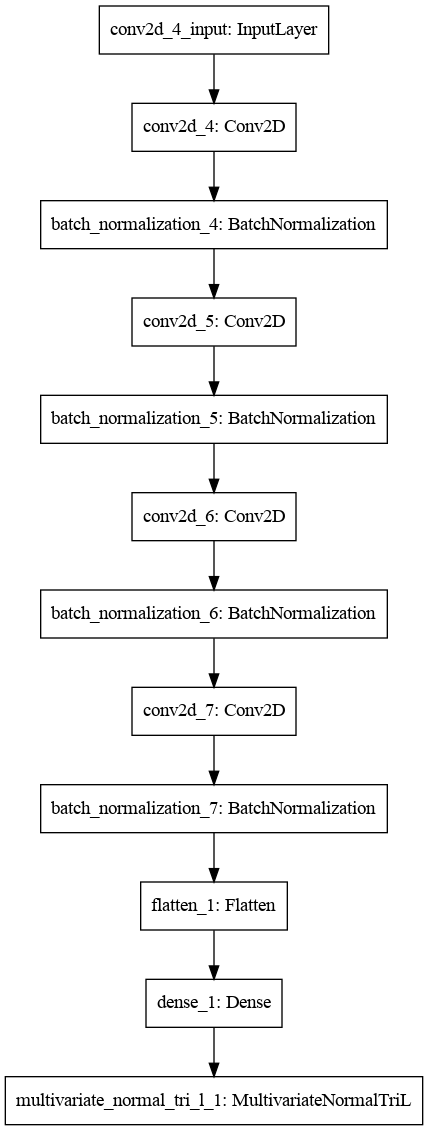

In [20]:
tf.keras.utils.plot_model(encoder)

## Define the decoder network

We'll define the decoder network for the VAE, which return IndependentBernoulli distribution of `event_shape=(64, 64, 3)`

In [21]:
def get_decoder(latent_dim):
    decoder = Sequential([
        Dense(4096, activation='relu', input_shape=(latent_dim, )),
        Reshape((4, 4, 256)),
        UpSampling2D(size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        Conv2D(3, (3, 3), padding='SAME'),
        Flatten(),
        tfpl.IndependentBernoulli(event_shape=(64, 64, 3))
    ])
    return decoder

In [22]:
# Run your function to get the decoder

decoder = get_decoder(latent_dim=50)

In [23]:
# Print the decoder summary

decoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              208896    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         295040    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 64)       

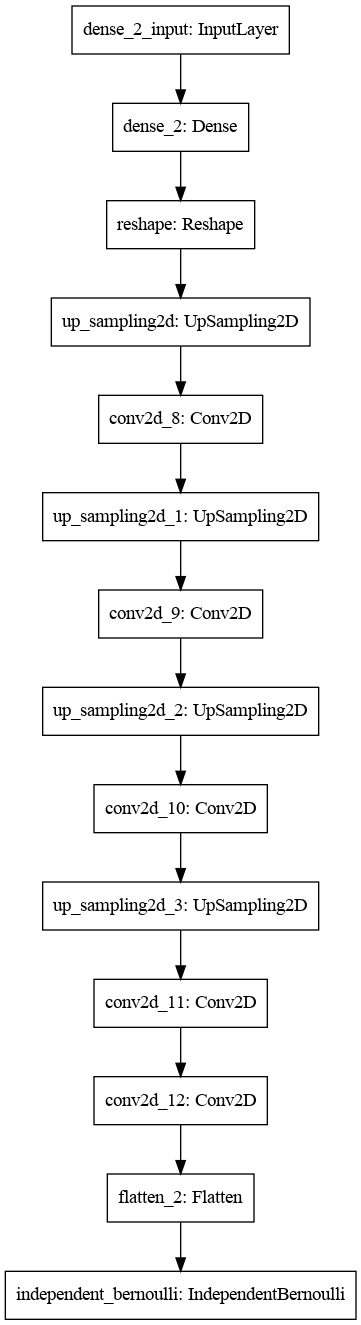

In [24]:
tf.keras.utils.plot_model(decoder)

## Link the encoder and decoder together

The following cell connects `encoder` and `decoder` to form the end-to-end architecture.

In [25]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

#### Define the average reconstruction loss

You should now define the reconstruction loss that forms the remaining part of the negative ELBO objective. This function should take a batch of images of shape `(batch_size, 64, 64, 3)` in the first argument, and the output of the decoder after passing the batch of images through `vae` in the second argument. 

The loss should be defined so that it returns
$$
    -\frac{1}{n}\sum_{i=1}^n \log p(x_i|z_i)
$$
where $n$ is the batch size and $z_i$ is sampled from $q(z|x_i)$, the encoding distribution a.k.a. the approximate posterior. The value of this expression is always a scalar.

Expression (1) is, as you know, is an estimate of the (negative of the) batch's average expected reconstruction loss:

$$
    -\frac{1}{n}\sum_{i=1}^n \mathrm{E}_{Z\sim q(z|x_i)}\big[\log p(x_i|Z)\big]
$$

In [26]:
def reconstruction_loss(batch_of_images, decoding_dist):
    """
    The function takes batch_of_images (Tensor containing a batch of input images to
    the encoder) and decoding_dist (output distribution of decoder after passing the 
    image batch through the encoder and decoder) as arguments.
    The function should return the scalar average expected reconstruction loss.
    """
    return -tf.reduce_mean(decoding_dist.log_prob(batch_of_images), axis=0)

## Compile and fit the model

It's now time to compile and train the model. Note that, it is recommand to use Hardware accelerator while training.

In [27]:
# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [29]:
vae.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30
313/313 [==============================] - 6s 19ms/step - loss: 6898.9551 - val_loss: 6774.6699
Epoch 2/30
313/313 [==============================] - 5s 16ms/step - loss: 6673.9536 - val_loss: 6601.0190
Epoch 3/30
313/313 [==============================] - 5s 16ms/step - loss: 6565.9702 - val_loss: 6534.0977
Epoch 4/30
313/313 [==============================] - 5s 16ms/step - loss: 6501.4233 - val_loss: 6488.2212
Epoch 5/30
313/313 [==============================] - 5s 16ms/step - loss: 6455.9448 - val_loss: 6454.4487
Epoch 6/30
313/313 [==============================] - 5s 16ms/step - loss: 6419.7598 - val_loss: 6418.2305
Epoch 7/30
313/313 [==============================] - 5s 16ms/step - loss: 6389.2236 - val_loss: 6404.3799
Epoch 8/30
313/313 [==============================] - 5s 16ms/step - loss: 6363.1782 - val_loss: 6377.2412
Epoch 9/30
313/313 [==============================] - 5s 16ms/step - loss: 6340.8530 - val_loss: 6350.7163
Epoch 10/30
313/313 [================

In [30]:
# Evaluate the model on the test set

test_loss = vae.evaluate(test_ds)
print("Test loss: {}".format(test_loss))

32/32 [==============================] - 0s 5ms/step - loss: 6327.6440
Test loss: 6327.64404296875


## Compute reconstructions of test images

We will now take a look at some image reconstructions from the encoder-decoder architecture.

You should complete the following function, that uses `encoder` and `decoder` to reconstruct images from the test dataset. This function takes the encoder, decoder and a Tensor batch of test images as arguments. The function should be completed according to the following specification:

* Get the mean of the encoding distributions from passing the batch of images into the encoder
* Pass these latent vectors through the decoder to get the output distribution

Your function should then return the mean of the output distribution, which will be a Tensor of shape `(batch_size, 64, 64, 3)`.

In [31]:
def reconstruct(encoder, decoder, batch_of_images):
    """
    The function takes the encoder, decoder and batch_of_images as inputs, which
    should be used to compute the reconstructions.
    The function should then return the reconstructions Tensor.
    """
    approx_posterior = encoder(batch_of_images)
    decoding_dist = decoder(approx_posterior.mean())
    return decoding_dist.mean()

In [32]:
# Run your function to compute reconstructions of random samples from the test dataset

n_reconstructions = 7
num_test_files = np.load('./dataset/vae-celeba/test.npy').shape[0]
test_ds_for_reconstructions = load_dataset('test')
for all_test_images, _ in test_ds_for_reconstructions.batch(num_test_files).take(1):
    all_test_images_np = all_test_images.numpy()
example_images = all_test_images_np[np.random.choice(num_test_files, n_reconstructions, replace=False)]

reconstructions = reconstruct(encoder, decoder, example_images).numpy()

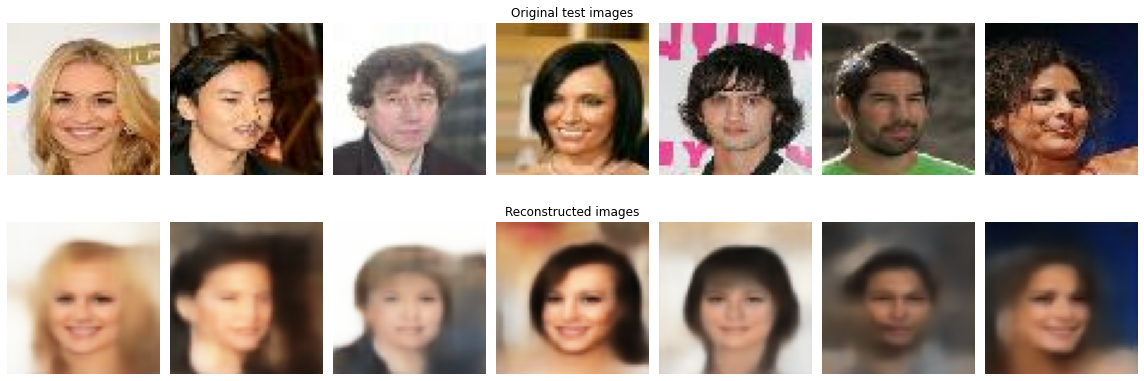

In [33]:
# Plot the reconstructions

f, axs = plt.subplots(2, n_reconstructions, figsize=(16, 6))
axs[0, n_reconstructions // 2].set_title("Original test images")
axs[1, n_reconstructions // 2].set_title("Reconstructed images")
for j in range(n_reconstructions):
    axs[0, j].imshow(example_images[j])
    axs[1, j].imshow(reconstructions[j])
    axs[0, j].axis('off')
    axs[1, j].axis('off')
    
plt.tight_layout();

## Sample new images from the generative model

Now we will sample from the generative model; that is, first sample latent vectors from the prior, and then decode those latent vectors with the decoder.

You should complete the following function to generate new images. This function takes the prior distribution and decoder network as arguments, as well as the number of samples to generate. This function should be completed according to the following:

* Sample a batch of `n_samples` images from the prior distribution, to obtain a latent vector Tensor of shape `(n_samples, 50)`
* Pass this batch of latent vectors through the decoder, to obtain an Independent Bernoulli distribution with batch shape equal to `[n_samples]` and event shape equal to `[64, 64, 3]`.

The function should then return the mean of the Bernoulli distribution, which will be a Tensor of shape `(n_samples, 64, 64, 3)`.

In [34]:
def generate_images(prior, decoder, n_samples):
    """
    The function takes the prior distribution, decoder and number of samples as inputs, which
    should be used to generate the images.
    The function should then return the batch of generated images.
    """
    z = prior.sample(n_samples)
    return decoder(z).mean()

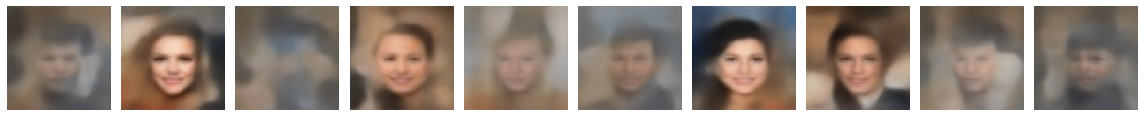

In [35]:
# Run your function to generate new images

n_samples = 10
sampled_images = generate_images(prior, decoder, n_samples)

f, axs = plt.subplots(1, n_samples, figsize=(16, 6))

for j in range(n_samples):
    axs[j].imshow(sampled_images[j])
    axs[j].axis('off')
    
plt.tight_layout();

## Modify generations with attribute vector

We will see how the latent space encodes high-level information about the images, even though it has not been trained with any information apart from the images themselves.

As mentioned in the introduction, each image in the CelebA dataset is labelled according to the attributes of the person pictured.

In [36]:
# Function to load labels and images as a numpy array

def load_labels_and_image_arrays(split):
    dataset = load_dataset(split)
    num_files = np.load('./dataset/vae-celeba/{}.npy'.format(split)).shape[0]
    
    for all_images, _ in dataset.batch(num_files).take(1):
        all_images_np = all_images.numpy()

    labels = pd.read_csv('./dataset/list_attr_celeba_subset.csv')
#     labels = labels[labels['image_id'].isin(files)]
    return labels[:num_files], all_images_np

In [37]:
# Load labels in a pandas DataFrame, training_subset is a numpy array

train_labels, training_subset = load_labels_and_image_arrays('train')

In [38]:
# List the attributes contained in the DataFrame

train_labels.columns[2:]

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

Each image is labelled with a binary indicator (1 is True, -1 is False) according to whether it possesses the attribute. 

In [39]:
# View a sample from the labels data

train_labels.sample(5)

Unnamed: 0    image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
4537        4537  075084.jpg                -1               -1          -1   
130          130  002109.jpg                -1                1           1   
2482        2482  041558.jpg                -1                1           1   
7298        7298  118456.jpg                -1                1           1   
3787        3787  062846.jpg                -1                1          -1   

      Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  ...  Sideburns  \
4537               -1    -1     -1        -1         1  ...         -1   
130                -1    -1     -1         1        -1  ...         -1   
2482               -1    -1     -1        -1        -1  ...         -1   
7298               -1    -1     -1         1        -1  ...         -1   
3787               -1    -1     -1         1        -1  ...         -1   

      Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  \
4537        1             -1         -1                 1           -1   
130        -1              1         -1                 1           -1   
2482        1             -1         -1                 1           -1   
7298        1             -1          1                 1           -1   
3787       -1             -1         -1                -1           -1   

      Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  Young  
4537                 1                -1               -1      1  
130                  1                 1               -1      1  
2482                 1                 1               -1      1  
7298                 1                -1               -1      1  
3787                 1                -1               -1      1  

[5 rows x 42 columns]

In [40]:
# Select an attribute

attribute = 'Smiling'

In [41]:
# Separate the images into those that have the attribute, and those that don't

attribute_mask = (train_labels[attribute] == 1)
images_with_attribute = training_subset[attribute_mask]

not_attribute_mask = (train_labels[attribute] == -1)
images_without_attribute = training_subset[not_attribute_mask]

### Get the 'attribute vector'

We will now encode each of the images that have the chosen attribute into the latent space by passing them through the encoder. We then average the latent codes obtained for all of these images to obtain a single latent code.

We then do the same for the images that do not have the chosen attribute. This gives an average latent code for images with the attribute, and an average latent code for images without the attribute. Intuitively speaking, the difference between these two vectors then gives us the 'direction' in latent space that corresponds to the presence of the attribute.

In [42]:
# Encode the images with and without the chosen attribute

encoded_images_with_attribute = encoder(images_with_attribute)
encoded_images_without_attribute = encoder(images_without_attribute)

In [43]:
# Average the latent vectors for each batch of encodings

mean_encoded_images_with_attribute = tf.reduce_mean(encoded_images_with_attribute.mean(), 
                                                    axis=0, keepdims=True)
mean_encoded_images_without_attribute = tf.reduce_mean(encoded_images_without_attribute.mean(), 
                                                    axis=0, keepdims=True)

In [44]:
# Get the attribute vector

attribute_vector = mean_encoded_images_with_attribute -  mean_encoded_images_without_attribute

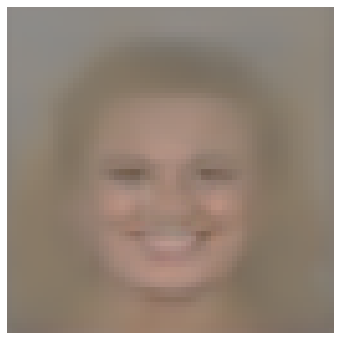

In [45]:
# Display the decoded attribute vector

decoded_a = decoder(attribute_vector).mean()
plt.imshow(decoded_a.numpy().squeeze())
plt.axis('off');

### Modify reconstructions using the attribute vector

We can now use the attribute vector to add the attribute to an image reconstruction, where that attribute wasn't present before. To do this, we can just add the attribute vector to the latent vector encoding of the image, and then decode the result. We can also adjust the strength of the attribute vector by scaling with a multiplicative parameter.

In [46]:
# Add the attribute vector to a sample of images that don't have the attribute

n_examples = 7
sampled_inx = np.random.choice(images_without_attribute.shape[0], n_examples, replace=False)
sample_images_without_attribute = images_without_attribute[sampled_inx]
sample_images_encodings = encoder(sample_images_without_attribute)
sample_images_reconstructions = decoder(sample_images_encodings).mean()

k = 2.5  # Weighting of attribute vector
modified_sample_images_encodings = sample_images_encodings + (k * attribute_vector)
modified_reconstructions = decoder(modified_sample_images_encodings).mean()

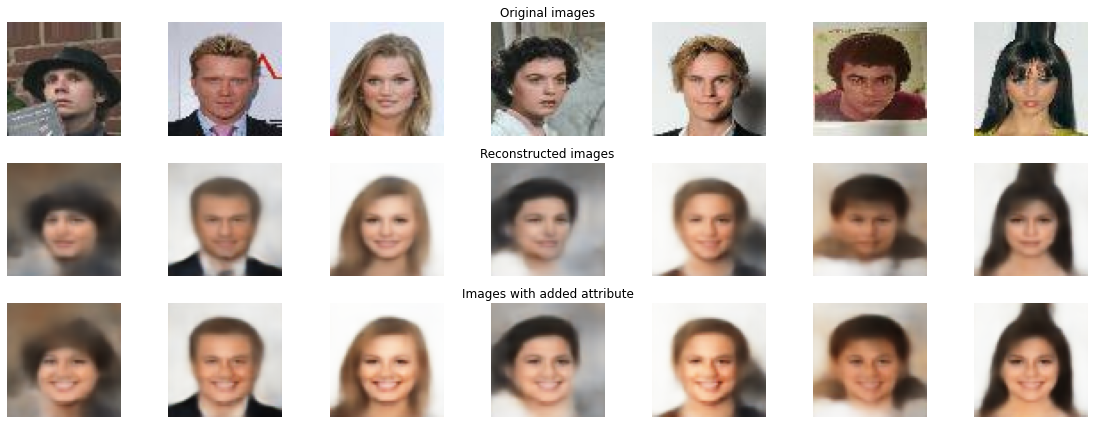

In [47]:
# Display the original images, their reconstructions, and modified reconstructions

f, axs = plt.subplots(3, n_examples, figsize=(16, 6))
axs[0, n_examples // 2].set_title("Original images")
axs[1, n_examples // 2].set_title("Reconstructed images")
axs[2, n_examples // 2].set_title("Images with added attribute")
for j in range(n_examples):
    axs[0, j].imshow(sample_images_without_attribute[j])
    axs[1, j].imshow(sample_images_reconstructions[j])
    axs[2, j].imshow(modified_reconstructions[j])
    for ax in axs[:, j]: ax.axis('off')
    
plt.tight_layout();